## imports

In [ ]:
import os
import requests
import numpy as np
import pickle

import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to track progress
from tqdm.notebook import tqdm

In [ ]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## get and read data

In [ ]:
# download zip

if not os.path.exists('anamoly_dataset.pickle'):
    url = "https://drive.google.com/u/0/uc?id=1CdYxeX8g9wxzSnz6R51ELmJJuuZ3xlqa&export=download"
    r = requests.get(url, allow_redirects=True)
    open('anamoly_dataset.pickle', 'wb').write(r.content)
    print('file downloaded')
else:
    print('file already exists')

file already exists


In [ ]:
infile = open('anamoly_dataset.pickle','rb')
data = pickle.load(infile)
infile.close()

train_in, train_out, test_in, test_out = data
train_in, val_in, train_out, val_out, = train_test_split(train_in, train_out, test_size=0.25, random_state=0)

In [ ]:
print(np.shape(train_in))
classes = np.unique(train_out)

(37500, 50, 3)


## visualize

class 0.0


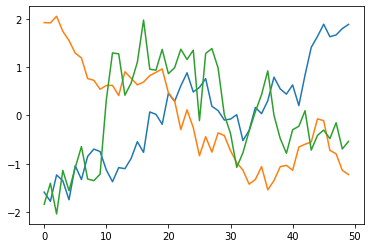

class 1.0


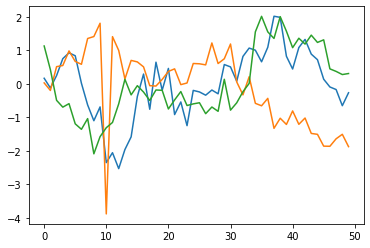

In [ ]:
for claSS in classes:
  first_indx = np.where(train_out==claSS)[0][0]
  print("class",claSS)
  sample = train_in[first_indx]
  plt.plot(sample)    # visualize a sample
  plt.show()

## create dataloader

In [ ]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inp, out):
    self.inp = inp
    self.out = out

  def __len__(self):
    return len(self.inp)

  def __getitem__(self, index):
    input = self.inp[index]
    label = self.out[index]
    return input,label


train_dataset = mydataset(train_in, train_out)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = mydataset(val_in, val_out)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

test_dataset = mydataset(test_in, test_out)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

## 1D-CNN AlexNet

### define the network

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool1d(6)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

tracking size as input passes through network

In [ ]:
def outSize(Lin,kernel_size,stride=1,padding=0):
  return np.floor((Lin + 2*padding - kernel_size)/stride + 1)

N=50; Cin=3; Lin=50
print("channel","seq_len")
print(Cin,'\t',Lin)
Cout=64; Lout=outSize(Lin,11,4,2)     # nn.Conv1d(3, 64, kernel_size=11, stride=4, padding=2),
print(Cout,'\t',Lout)
Lout=outSize(Lout,3,2,0)              # nn.MaxPool1d(kernel_size=3, stride=2),
print(Cout,'\t',Lout)
Cout=192; Lout=outSize(Lout,5,1,2)    # nn.Conv1d(64, 192, kernel_size=5, padding=2),
print(Cout,'\t',Lout)
Lout=outSize(Lout,3,2,0)              # nn.MaxPool1d(kernel_size=3, stride=2),
print(Cout,'\t',Lout)
Cout=384; Lout=outSize(Lout,3,1,1)    # nn.Conv1d(192, 384, kernel_size=3, padding=1),
print(Cout,'\t',Lout)
Cout=256; Lout=outSize(Lout,3,1,1)    # nn.Conv1d(256, 256, kernel_size=3, padding=1),
print(Cout,'\t',Lout)
Lout=outSize(Lout,2,2,0)              # nn.MaxPool1d(kernel_size=3, stride=2),
print(Cout,'\t',Lout)

channel seq_len
3 	 50
64 	 11.0
64 	 5.0
192 	 5.0
192 	 2.0
384 	 2.0
256 	 2.0
256 	 1.0


define function to train the model

In [ ]:
def trainNet(net,criterion,optimizer,train_loader,val_loader,epochs):

  print("training network")
  check_every = int(epochs / 10)

  avg_trainLosses = []
  avg_valLosses = []

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []

    net.train()
    for i, (inputBatch,outTrueBatch) in enumerate(tqdm(train_loader, leave=False)):

      inputBatch = inputBatch.to(device).float()
      inputBatch = inputBatch.transpose(1,2)
      outTrueBatch = outTrueBatch.to(device).long()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      outPredBatch = net(inputBatch)
      loss = criterion(outPredBatch, outTrueBatch)
      train_loss.append(loss.item())

      # backward + optimize
      loss.backward()
      optimizer.step()

    net.eval()
    for i, (inputBatch,outTrueBatch) in enumerate(tqdm(val_loader, leave=False)):
      with torch.no_grad():

        inputBatch = inputBatch.to(device).float()
        inputBatch = inputBatch.transpose(1,2)
        outTrueBatch = outTrueBatch.to(device).long()

        # forward
        outPredBatch = net(inputBatch)
        loss = criterion(outPredBatch, outTrueBatch)
        val_loss.append(loss.item())

    avg_trainLoss = np.mean(train_loss)
    avg_valLoss = np.mean(val_loss)

    avg_trainLoss = np.mean(train_loss)
    avg_valLoss = np.mean(val_loss)
    avg_trainLosses.append(avg_trainLoss)
    avg_valLosses.append(avg_valLoss) 

    # print statistics
    if epoch % check_every == check_every - 1:
      print('epoch: %d, train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss))

  print('Finished Training')
  plt.plot(avg_trainLosses, label='train loss')
  plt.plot(avg_valLosses, label='val loss')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return

### create network

In [ ]:
model = AlexNet().to(device)
print("params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

params: 23862466


### train

training network


epoch: 1, train loss: 0.229, val loss: 0.128


epoch: 2, train loss: 0.115, val loss: 0.119


epoch: 3, train loss: 0.099, val loss: 0.106


epoch: 4, train loss: 0.090, val loss: 0.112


epoch: 5, train loss: 0.080, val loss: 0.093


epoch: 6, train loss: 0.074, val loss: 0.093


epoch: 7, train loss: 0.072, val loss: 0.093


epoch: 8, train loss: 0.061, val loss: 0.085


epoch: 9, train loss: 0.056, val loss: 0.094


epoch: 10, train loss: 0.056, val loss: 0.090

Finished Training


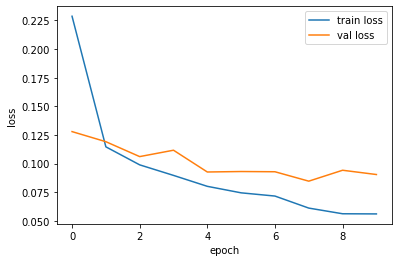

In [ ]:
trainNet(model, criterion, optimizer, train_loader, val_loader, epochs=10)

In [ ]:
#torch.save(model.state_dict(), "checkpoint.pt")
model.load_state_dict(torch.load("checkpoint.pt", map_location=device))

<All keys matched successfully>

### evaluate

define function to evluate the model

In [ ]:
def evaluate(net, loader):

  net.eval()
  outTrue = []
  outPred = []

  for i, (inputBatch,outTrueBatch) in enumerate(tqdm(loader)):
    with torch.no_grad():

      inputBatch = inputBatch.to(device).float()
      inputBatch = inputBatch.transpose(1,2)
      outTrue.extend(outTrueBatch.cpu())

      # forward
      outPredBatch = net(inputBatch).argmax(1)
      outPred.extend(outPredBatch.cpu())

  print(classification_report(outTrue, outPred, digits=4))

In [ ]:
evaluate(model,test_loader)


              precision    recall  f1-score   support

         0.0     0.9775    0.9958    0.9866      8304
         1.0     0.9773    0.8880    0.9305      1696

    accuracy                         0.9775     10000
   macro avg     0.9774    0.9419    0.9585     10000
weighted avg     0.9775    0.9775    0.9771     10000



## saliency map

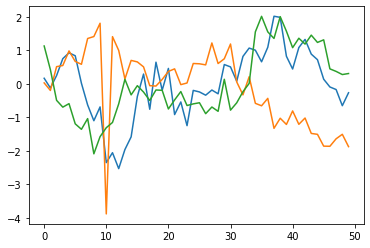

In [ ]:
anomaly_sample = train_in[np.where(train_out==1)[0][0]]
plt.plot(anomaly_sample)    # visualize a sample
plt.show()

In [ ]:
def salMap(model, sample):

  sample = torch.from_numpy(sample).to(device).float()
  sample = sample.unsqueeze(0).transpose(1,2)
  _ = sample.requires_grad_()

  model.eval()
  # Retrieve output from the image
  output = model(sample)

  # Catch the output
  output_idx = output.argmax()
  output_max = output[0, output_idx]
  print("prediction:",output_idx)

  # Do backpropagation to get the derivative of the output based on the image
  output_max.backward()

  # Retireve the saliency map and also pick the maximum value from channels on each time stamp.
  # In this case, we look at dim=1. Recall the shape (batch_size, channel, time_stamp)
  saliency, _ = torch.max(sample.grad.data.abs(), dim=1)
  saliency = saliency.view(-1).cpu()
  impPts, impIndxs = saliency.sort(descending=True)
  impPts, impIndxs = impPts[:5], impIndxs[:5]

  # Visualize the image and the saliency map
  fig, ax = plt.subplots(1, 2, figsize=(12,4))
  ax[0].plot(sample.squeeze(0).transpose(0,1).cpu().detach().numpy())
  ax[0].set_title("anomaly sample")
  #ax[0].axis('off')
  ax[1].plot(saliency)
  ax[1].scatter(impIndxs,impPts)
  ax[1].set_title("saliency map")
  #ax[1].axis('off')
  plt.tight_layout()
  plt.show()

  return impIndxs

prediction: tensor(1)


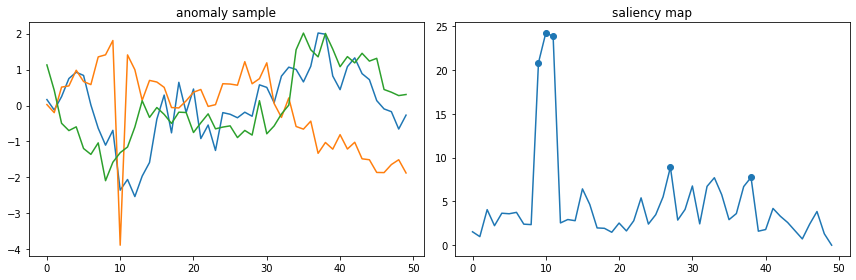

tensor([10, 11,  9, 27, 38])


In [ ]:
impIndxs = salMap(model,anomaly_sample)
print(impIndxs)

### replace important points

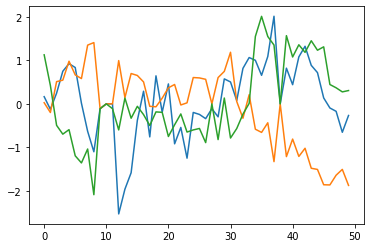

In [ ]:
synthetic_sample = anomaly_sample
channelMeans = np.mean(synthetic_sample, axis=0)
nPts = impIndxs.shape
channelMeans = channelMeans.repeat(nPts).reshape(-1,3)
synthetic_sample[impIndxs] = channelMeans

plt.plot(synthetic_sample)    # visualize a sample
plt.show()

prediction: tensor(0)


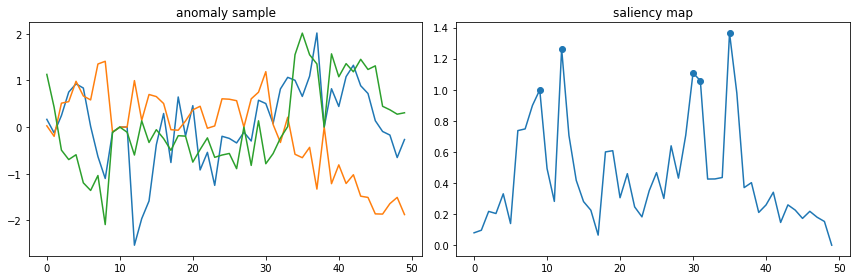

In [ ]:
_ = salMap(model,synthetic_sample)

## Answers

1) Replacing points to measure impact\
&nbsp; i) just use the important points and set other values to 0\
&nbsp;  ii) swapping the important points with points at some other time steps

2) Attribution methods in image domain\
&nbsp;  i) Perturbation based method – Occlusion\
&nbsp;&nbsp; removing or masking parts of images\
&nbsp;  ii) Backprop based methods\
&nbsp;&nbsp; Gradients, DeConvNet and Guided Backprop